In [10]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score, mean_absolute_error, mean_absolute_percentage_error
from sklearn.preprocessing import minmax_scale, StandardScaler
import matplotlib
import seaborn as sns
import torch
import torch.nn as nn
from torch.utils import data
from sklearn.model_selection import train_test_split
from torch.utils.tensorboard import SummaryWriter
import torch.nn.functional as F
from torchmetrics import R2Score

Text(0.5, 1.0, 'Drill holes - plan view')

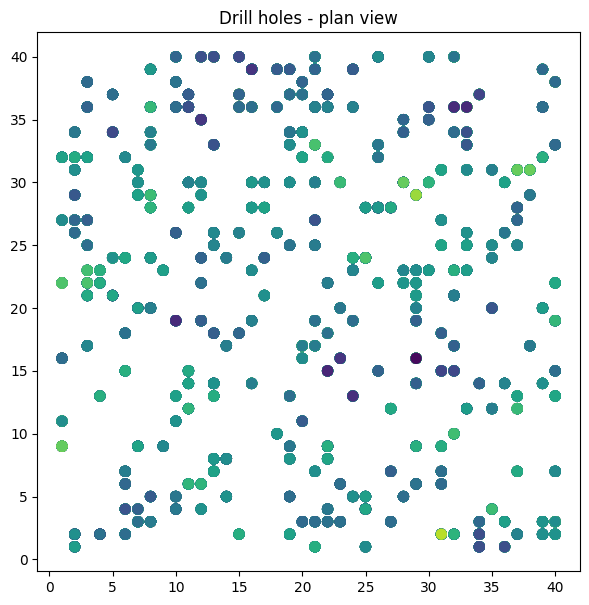

In [11]:
df_simulation = pd.read_csv('data/simulation_data.csv')

grid_size = max(df_simulation['x'].max(),df_simulation['y'].max(),df_simulation['y'].max())

numer_of_drillholes = 300

df_simulation[['x','y','z']] = df_simulation[['x','y','z']].astype(float)
x_y_grid = np.array(np.meshgrid(np.arange(1,grid_size+1,1), np.arange(1,grid_size+1,1))).T.reshape(-1,2)
df_simulation_sample = pd.DataFrame(columns=['x','y','z','finos'])
for item in np.random.default_rng().choice(x_y_grid,numer_of_drillholes):
    df_temp = df_simulation[(df_simulation['x']==item[0]) & (df_simulation['y']==item[1])]
    df_simulation_sample = pd.concat([df_temp, df_simulation_sample])



fig = plt.gcf()
fig.set_size_inches(7,7)
plt.scatter(df_simulation_sample['x'],df_simulation_sample['y'],
c=df_simulation_sample['finos'], marker='o', s=50)
plt.title('Drill holes - plan view')

In [12]:
df_simulation_sample = pd.concat([df_simulation_sample, df_simulation.sample(600)])
df_simulation_sample.drop_duplicates(inplace=True)
df_simulation_sample

,x,y,z,finos,litho,alter
56520,36.0,14.0,1.0,4.392977,Litho_B,Alter_C
56521,36.0,14.0,2.0,3.857274,Litho_C,Alter_C
56522,36.0,14.0,3.0,3.360252,Litho_C,Alter_B
56523,36.0,14.0,4.0,3.630897,Litho_B,Alter_A
56524,36.0,14.0,5.0,4.152941,Litho_B,Alter_B
...,...,...,...,...,...,...
46328,29.0,39.0,9.0,4.312501,Litho_B,Alter_B
6980,5.0,15.0,21.0,4.891974,Litho_B,Alter_D
38751,25.0,9.0,32.0,3.280009,Litho_A,Alter_A
62142,39.0,34.0,23.0,2.860752,Litho_B,Alter_C


In [13]:
df_sample = pd.get_dummies(df_simulation_sample)
columns = df_sample.columns.tolist()
columns.remove('finos')
columns.append('finos')
df_sample = df_sample[columns]

df = pd.get_dummies(df_simulation)
columns = df.columns.tolist()
columns.remove('finos')
columns.append('finos')
df = df[columns]

sc = StandardScaler()
sc.fit(df[['x','y','z']])
df[['x','y','z']] = sc.transform(df[['x','y','z']])
df_sample[['x','y','z']] = sc.transform(df_sample[['x','y','z']])

In [14]:
class Data(torch.utils.data.Dataset):
  def __init__(self, X: pd.DataFrame, y: pd.DataFrame, device) -> None:
    # need to convert float64 to float32 else
    # will get the following error
    # RuntimeError: expected scalar type Double but found Float
    self.X = torch.from_numpy(X.to_numpy().astype(np.float32)).to(device)
    self.y = torch.from_numpy(y.to_numpy().astype(np.float32)).to(device)
    self.len = self.X.shape[0]
  def __getitem__(self, index: int) -> tuple:
    return self.X[index], self.y[index]
  def __len__(self) -> int:
    return self.len

# Define la clase de la red neuronal con atención
class MineralPredictionNet(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(MineralPredictionNet, self).__init__()
        self.fc1 = nn.Linear(input_size, 25*hidden_size)
        self.attention = nn.Linear(25*hidden_size, 1)
        self.fc2 = nn.Linear(25*hidden_size, 125*hidden_size)
        self.fc3 = nn.Linear(125*hidden_size, 25*hidden_size)
        self.fc4 = nn.Linear(25*hidden_size, output_size)

    def forward(self, x):
        # Procesa los datos de entrada a través de la primera capa fully-connected
        a = self.fc1(x)
        
        # Aplica la atención a la salida de la primera capa fully-connected
        attention_weights = F.softmax(self.attention(a), dim=1)
        a = a * attention_weights
        a = nn.ReLU()(a)
        a = self.fc2(a)
        a = nn.ReLU()(a)
        a = self.fc3(a)
        a = nn.ReLU()(a)
        a = self.fc4(a)
        
        return a

In [23]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Define el tamaño de entrada, oculto y salida de la red neuronal
X = df_sample.iloc[:,:-1]
y = df_sample.iloc[:,-1]

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=0)

train = Data(X_train, y_train,device)
val = Data(X_val, y_val,device)
real = Data(df.iloc[:,:-1],df.iloc[:,-1], device)

train_loader = data.DataLoader(train, batch_size=400)
val_loader = data.DataLoader(val, batch_size=400)
real_loader = data.DataLoader(real)

input_size = X.shape[1]  # 3 coordenadas XYZ y n_litologies litologías
hidden_size = 32
output_size = 1  # Ley mineral del yacimiento

# Inicializa la red neuronal
model = MineralPredictionNet(input_size, 5, output_size)
model.to(device)
model.load_state_dict(torch.load('models/Attentional_03.pth'))
model.train(True)
# Define la función de pérdida y el optimizador
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.0003)

writer = SummaryWriter()

torch_r2 = R2Score().to(device=device)

In [24]:
# Repite el proceso de entrenamiento y validación varias veces
epoch = 0
# loss_list=[]
# val_list = []
# r2_list = []
while True:
    epoch = epoch+1
    # Itera a través de los datos de entrenamiento
    running_loss = []
    running_val = []
    r2_epoch = []

    for x, y in train_loader:
        # Predice la salida usando la red neuronal
        y_pred = model(x)
        y_pred = y_pred.squeeze()
        loss = criterion(y_pred, y)

        # Realiza el backpropagation y actualiza los parámetros
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        running_loss.append(loss.item())
    # loss_list.append(sum(running_loss)/len(running_loss))

    # Itera a través de los datos de validación
    
    for x,y in val_loader:
        # Convierte los datos a tensores de PyTorch

        # Predice la salida usando la red neuronal
        y_pred = model(x)
        y_pred = y_pred.squeeze()
        # Calcula la pérdida
        val = criterion(y_pred, y)
        r = torch_r2(y_pred, y).item()
        r2_epoch.append(r)
        running_val.append(val.item())

    # val_list.append(sum(running_val)/len(running_val))
    # r2_list.append(sum(r2_score)/len(r2_score))
    writer.add_scalar("Loss/train_batch", loss, epoch)
    writer.add_scalar("Validation/train_batch", val, epoch)
    writer.add_scalar("Metrics/r2_batch", r, epoch)
    writer.add_scalar("Loss/train_epoch", sum(running_loss)/len(running_loss), epoch)
    writer.add_scalar("Validation/train_epoch", sum(running_val)/len(running_val), epoch)
    writer.add_scalar("Metrics/r2_epoch", sum(r2_epoch)/len(r2_epoch), epoch)
    print("Current epoch:", epoch)
    

Current epoch: 1
Current epoch: 2
Current epoch: 3
Current epoch: 4
Current epoch: 5
Current epoch: 6
Current epoch: 7
Current epoch: 8
Current epoch: 9
Current epoch: 10
Current epoch: 11
Current epoch: 12
Current epoch: 13
Current epoch: 14
Current epoch: 15
Current epoch: 16
Current epoch: 17
Current epoch: 18
Current epoch: 19
Current epoch: 20
Current epoch: 21
Current epoch: 22
Current epoch: 23
Current epoch: 24
Current epoch: 25
Current epoch: 26
Current epoch: 27
Current epoch: 28
Current epoch: 29
Current epoch: 30
Current epoch: 31
Current epoch: 32
Current epoch: 33
Current epoch: 34
Current epoch: 35
Current epoch: 36
Current epoch: 37
Current epoch: 38
Current epoch: 39
Current epoch: 40
Current epoch: 41
Current epoch: 42
Current epoch: 43
Current epoch: 44
Current epoch: 45
Current epoch: 46
Current epoch: 47
Current epoch: 48
Current epoch: 49
Current epoch: 50
Current epoch: 51
Current epoch: 52
Current epoch: 53
Current epoch: 54
Current epoch: 55
Current epoch: 56
C

KeyboardInterrupt: 

r2:  0.16680220489051067
mae:  0.6406769634765224
mape:  222653067559.0748


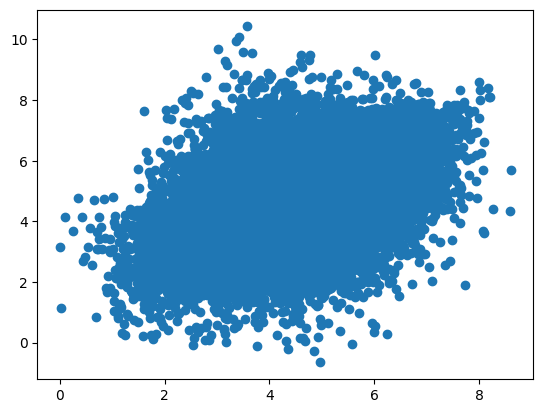

In [25]:
y_pred = []
y_real = []
for x,y in real_loader:
    y_p = model(x)
    y_pred.append(y_p.item())
    y_real.append(y.item())

print("r2: ", r2_score(y_real, y_pred))
print("mae: ", mean_absolute_error(y_real, y_pred))
print("mape: ", mean_absolute_percentage_error(y_real, y_pred))
plt.scatter(y_real, y_pred)

In [22]:
torch.save(model.state_dict(), 'models/Attentional_04.pth')